## Deep Learning on FashionMNIST

*Import Libraries*

In [3]:
import time
import numpy as np
#from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
import matplotlib.pyplot as plt

*Function Def*

In [4]:
def load_fashion_mnist_dataset():
    from keras.datasets import fashion_mnist
    ((x_train, y_train), (x_test, y_test)) = fashion_mnist.load_data()
    return (x_train, y_train), (x_test, y_test)


# Visualizar 6 imagens do mnist numa escala de cinzentos
def visualize_fashion_mnist():
    (X_train, y_train), (X_test, y_test) = load_fashion_mnist_dataset()
    plt.subplot(321)
    plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
    plt.subplot(322)
    plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
    plt.subplot(323)
    plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
    plt.subplot(324)
    plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
    plt.subplot(325)
    plt.imshow(X_train[4], cmap=plt.get_cmap('gray'))
    plt.subplot(326)
    plt.imshow(X_train[5], cmap=plt.get_cmap('gray'))
    plt.show()

4423680/4422102 [==============================] - 3s 1us/step


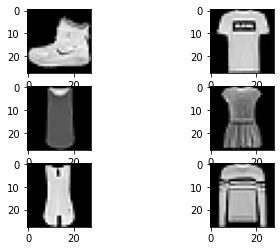

In [5]:
visualize_fashion_mnist()